
# Magnetic inversion on a TreeMesh with remanence

In this example, we demonstrate the use of a Magnetic Vector Inversion
on 3D TreeMesh for the inversion of magnetics affected by remanence.
The mesh is auto-generated based
on the position of the observation locations and topography.

We invert the data twice, first for a smooth starting model using the
Cartesian coordinate system, and second for a compact model using
the Spherical formulation.

The inverse problem uses the :class:`simpeg.regularization.Sparse`.


In [1]:
from simpeg import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
)

from simpeg import utils
from simpeg.utils import mkvc

from discretize.utils import active_from_xyz, mesh_builder_xyz
from simpeg.potential_fields import magnetics
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt


# sphinx_gallery_thumbnail_number = 3

## Setup

Define the survey and model parameters

First we need to define the direction of the inducing field
As a simple case, we pick a vertical inducing field of magnitude 50,000 nT.





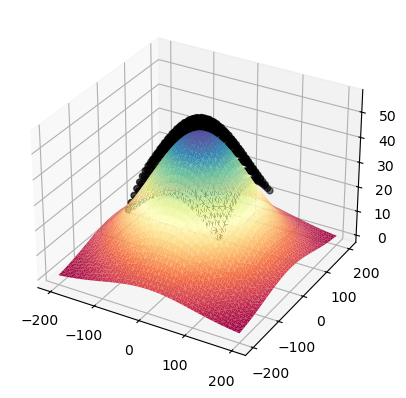

In [2]:
np.random.seed(1)
# We will assume a vertical inducing field
h0_amplitude, h0_inclination, h0_declination = (50000.0, 90.0, 0.0)

# The magnetization is set along a different direction (induced + remanence)
M = np.array([45.0, 90.0])

# Create grid of points for topography
# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(np.linspace(-200, 200, 50), np.linspace(-200, 200, 50))
b = 100
A = 50
zz = A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))

topo = np.c_[utils.mkvc(xx), utils.mkvc(yy), utils.mkvc(zz)]

# Create an array of observation points
xr = np.linspace(-100.0, 100.0, 20)
yr = np.linspace(-100.0, 100.0, 20)
X, Y = np.meshgrid(xr, yr)
Z = A * np.exp(-0.5 * ((X / b) ** 2.0 + (Y / b) ** 2.0)) + 5

# Create a MAGsurvey
xyzLoc = np.c_[mkvc(X.T), mkvc(Y.T), mkvc(Z.T)]
rxLoc = magnetics.receivers.Point(xyzLoc)
srcField = magnetics.sources.UniformBackgroundField(
    receiver_list=[rxLoc],
    amplitude=h0_amplitude,
    inclination=h0_inclination,
    declination=h0_declination,
)
survey = magnetics.survey.Survey(srcField)

# Here how the topography looks with a quick interpolation, just a Gaussian...
tri = sp.spatial.Delaunay(topo)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot_trisurf(
    topo[:, 0], topo[:, 1], topo[:, 2], triangles=tri.simplices, cmap=plt.cm.Spectral
)
ax.scatter3D(xyzLoc[:, 0], xyzLoc[:, 1], xyzLoc[:, 2], c="k")
plt.show()

## Inversion Mesh

Here, we create a TreeMesh with base cell size of 5 m. We created a small
utility function to center the mesh around points and to figure out the
outermost dimension for adequate padding distance.
The second stage allows us to refine the mesh around points or surfaces
(point assumed to follow some horizontal trend)
The refinement process is repeated twice to allow for a finer level around
the survey locations.




In [3]:
# Create a mesh
h = [5, 5, 5]
padDist = np.ones((3, 2)) * 100

mesh = mesh_builder_xyz(
    xyzLoc, h, padding_distance=padDist, depth_core=100, mesh_type="tree"
)
mesh.refine_surface(topo, padding_cells_by_level=[4, 4], finalize=True)


# Define an active cells from topo
actv = active_from_xyz(mesh, topo)
nC = int(actv.sum())

C:\Users\Marco Couto\miniconda3\envs\veraoiag2026\Lib\site-packages\discretize\utils\mesh_utils.py:528: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  mesh = discretize.TreeMesh(h_dim, diagonal_balance=tree_diagonal_balance)


## Forward modeling data

We can now create a magnetization model and generate data
Lets start with a block below topography




C:\Users\Marco Couto\AppData\Local\Temp\ipykernel_7872\2791739024.py:7: BreakingChangeWarning: Since SimPEG v0.25.0, the 'get_indices_block' function returns a single array with the cell indices, instead of a tuple with a single element. This means that we don't need to unpack the tuple anymore to access to the cell indices.
If you were using this function as in:

    ind = get_indices_block(p0, p1, mesh.cell_centers)[0]

Make sure you update it to:

    ind = get_indices_block(p0, p1, mesh.cell_centers)

To hide this warning, add this to your script or notebook:

    import warnings
    from simpeg.utils import BreakingChangeWarning

    warnings.filterwarnings(action='ignore', category=BreakingChangeWarning)

  ind = utils.model_builder.get_indices_block(


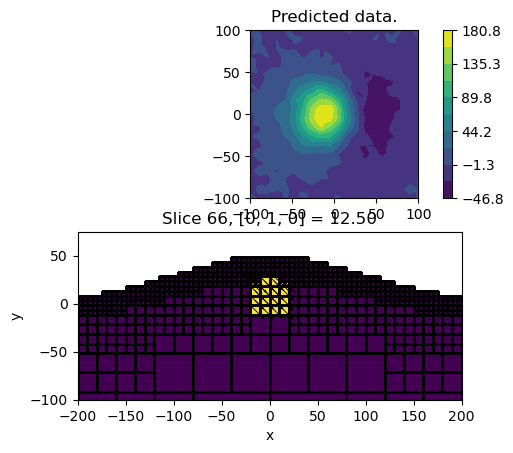

In [4]:
model = np.zeros((mesh.nC, 3))

# Convert the inclination declination to vector in Cartesian
M_xyz = utils.mat_utils.dip_azimuth2cartesian(M[0], M[1])

# Get the indices of the magnetized block
ind = utils.model_builder.get_indices_block(
    np.r_[-20, -20, -10],
    np.r_[20, 20, 25],
    mesh.gridCC,
)

# Assign magnetization values
model[ind, :] = np.kron(np.ones((ind.size, 1)), M_xyz * 0.05)

# Remove air cells
model = model[actv, :]

# Create active map to go from reduce set to full
actvMap = maps.InjectActiveCells(mesh, actv, np.nan)

# Creat reduced identity map
idenMap = maps.IdentityMap(nP=nC * 3)

# Create the simulation
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey, mesh=mesh, chiMap=idenMap, active_cells=actv, model_type="vector"
)

# Compute some data and add some random noise
d = simulation.dpred(mkvc(model))
std = 5  # nT
synthetic_data = d + np.random.randn(len(d)) * std
wd = np.ones(len(d)) * std

# Assign data and uncertainties to the survey
data_object = data.Data(survey, dobs=synthetic_data, standard_deviation=wd)

# Create an projection matrix for plotting later
actv_plot = maps.InjectActiveCells(mesh, actv, np.nan)

# Plot the model and data
plt.figure()
ax = plt.subplot(2, 1, 1)
im = utils.plot_utils.plot2Ddata(xyzLoc, synthetic_data, ax=ax)
plt.colorbar(im[0])
ax.set_title("Predicted data.")
plt.gca().set_aspect("equal", adjustable="box")

# Plot the vector model
ax = plt.subplot(2, 1, 2)
mesh.plot_slice(
    actv_plot * model.reshape((-1, 3), order="F"),
    v_type="CCv",
    view="vec",
    ax=ax,
    normal="Y",
    ind=66,
    grid=True,
    quiver_opts={
        "pivot": "mid",
        "scale": 5 * np.abs(model).max(),
        "scale_units": "inches",
    },
)
ax.set_xlim([-200, 200])
ax.set_ylim([-100, 75])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")

plt.show()

## Inversion

We can now attempt the inverse calculations. We put great care
into designing an inversion methology that would yield a geologically
reasonable solution for the non-induced problem.
The inversion is done in two stages. First we compute a smooth
solution using a Cartesian coordinate system, then a sparse
inversion in the Spherical domain.




In [5]:
# Create sensitivity weights from our linear forward operator
rxLoc = survey.source_field.receiver_list[0].locations

# This Mapping connects the regularizations for the three-component
# vector model
wires = maps.Wires(("p", nC), ("s", nC), ("t", nC))


m0 = np.ones(3 * nC) * 1e-4  # Starting model

# Create three regularizations for the different components
# of magnetization
reg_p = regularization.Sparse(mesh, active_cells=actv, mapping=wires.p)
reg_p.reference_model = np.zeros(3 * nC)

reg_s = regularization.Sparse(mesh, active_cells=actv, mapping=wires.s)
reg_s.reference_model = np.zeros(3 * nC)

reg_t = regularization.Sparse(mesh, active_cells=actv, mapping=wires.t)
reg_t.reference_model = np.zeros(3 * nC)

reg = reg_p + reg_s + reg_t
reg.reference_model = np.zeros(3 * nC)

# Data misfit function
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1.0 / data_object.standard_deviation

# Add directives to the inversion
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=-10, upper=10.0, maxIterLS=20, cg_maxiter=20, cg_rtol=1e-3
)

invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)

# A list of directive to control the inverson
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# Here is where the norms are applied
# Use a threshold parameter empirically based on the distribution of
#  model parameters
IRLS = directives.UpdateIRLS(
    f_min_change=1e-3, max_irls_iterations=2, misfit_tolerance=5e-1
)

# Pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()

inv = inversion.BaseInversion(
    invProb, directiveList=[sensitivity_weights, IRLS, update_Jacobi, betaest]
)

# Run the inversion
mrec_MVIC = inv.run(m0)


Running inversion with SimPEG v0.25.0
================================================= Projected GNCG =================================================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS   iter_CG   CG |Ax-b|/|b|  CG |Ax-b|   Comment   
-----------------------------------------------------------------------------------------------------------------
   0  1.03e+06  2.25e+04  2.40e-03  2.50e+04                         0           inf          inf                
   1  1.03e+06  1.43e+04  4.30e-03  1.88e+04    3.56e+03      0      20       6.64e-01     5.11e+05              
   2  5.17e+05  9.87e+03  8.87e-03  1.45e+04    3.03e+03      0      13       7.49e-04     2.84e+02              
   3  2.59e+05  5.97e+03  1.97e-02  1.11e+04    2.52e+03      0      14       6.00e-04     8.51e+01              
   4  1.29e+05  3.00e+03  3.58e-02  7.63e+03    2.34e+03      0      15       6.44e-04     6.67e+01              
   5  6.47e+04  1.29e+03  5.42e-02  4.79e+03    

## Sparse Vector Inversion

Re-run the MVI in the spherical domain so we can impose
sparsity in the vectors.





In [6]:
spherical_map = maps.SphericalSystem()
m_start = utils.mat_utils.cartesian2spherical(mrec_MVIC.reshape((nC, 3), order="F"))
beta = invProb.beta
dmis.simulation.chiMap = spherical_map
dmis.simulation.model = m_start

# Create a block diagonal regularization
wires = maps.Wires(("amp", nC), ("theta", nC), ("phi", nC))

# Create a Combo Regularization
# Regularize the amplitude of the vectors
reg_a = regularization.Sparse(
    mesh,
    gradient_type="total",
    active_cells=actv,
    mapping=wires.amp,
    norms=[0.0, 1.0, 1.0, 1.0],  # Only norm on gradients used,
    reference_model=np.zeros(3 * nC),
)

# Regularize the vertical angle of the vectors
reg_t = regularization.Sparse(
    mesh,
    gradient_type="total",
    active_cells=actv,
    mapping=wires.theta,
    alpha_s=0.0,  # No reference angle,
    norms=[0.0, 1.0, 1.0, 1.0],  # Only norm on gradients used,
)
reg_t.units = "radian"

# Regularize the horizontal angle of the vectors
reg_p = regularization.Sparse(
    mesh,
    gradient_type="total",
    active_cells=actv,
    mapping=wires.phi,
    alpha_s=0.0,  # No reference angle,
    norms=[0.0, 1.0, 1.0, 1.0],  # Only norm on gradients used,
)
reg_p.units = "radian"

reg = reg_a + reg_t + reg_p
reg.reference_model = np.zeros(3 * nC)

lower_bound = np.kron(np.asarray([0, -np.inf, -np.inf]), np.ones(nC))
upper_bound = np.kron(np.asarray([10, np.inf, np.inf]), np.ones(nC))

# Add directives to the inversion
opt = optimization.ProjectedGNCG(
    maxIter=20,
    lower=lower_bound,
    upper=upper_bound,
    maxIterLS=20,
    cg_maxiter=30,
    cg_rtol=1e-3,
    active_set_grad_scale=1e-3,
)
opt.approxHinv = None

invProb = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=beta)

# Here is where the norms are applied
irls = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=20,
    misfit_tolerance=0.5,
)
scale_spherical = directives.SphericalUnitsWeights(
    amplitude=wires.amp, angles=[reg_t, reg_p]
)
# Special directive specific to the mag amplitude problem. The sensitivity
# weights are updated between each iteration.
spherical_projection = directives.ProjectSphericalBounds()
sensitivity_weights = directives.UpdateSensitivityWeights()
update_Jacobi = directives.UpdatePreconditioner()

inv = inversion.BaseInversion(
    invProb,
    directiveList=[
        scale_spherical,
        spherical_projection,
        irls,
        sensitivity_weights,
        update_Jacobi,
    ],
)

mrec_MVI_S = inv.run(m_start)

INFO: simpeg.InvProblem will set Regularization.reference_model to m0.
INFO: simpeg.InvProblem will set Regularization.reference_model to m0.



Running inversion with SimPEG v0.25.0
================================================= Projected GNCG =================================================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS   iter_CG   CG |Ax-b|/|b|  CG |Ax-b|   Comment   
-----------------------------------------------------------------------------------------------------------------
   0  1.62e+04  3.36e+02  1.34e-01  2.51e+03                         0           inf          inf                
   1  1.62e+04  5.23e+02  1.15e-01  2.39e+03    1.13e+03      1      30       4.85e-02     6.70e+02              
   2  8.08e+03  5.17e+02  1.12e-01  1.42e+03    1.21e+03      5      30       2.77e-02     2.15e+03              
   3  4.04e+03  4.81e+02  1.12e-01  9.35e+02    1.23e+03      3      30       2.45e-02     2.07e+03              
   4  2.02e+03  3.83e+02  1.47e-01  6.80e+02    1.23e+03      0      30       5.77e-03     5.44e+02              
Reached starting chifact with l2-norm regulariza

## Final Plot

Let's compare the smooth and compact model






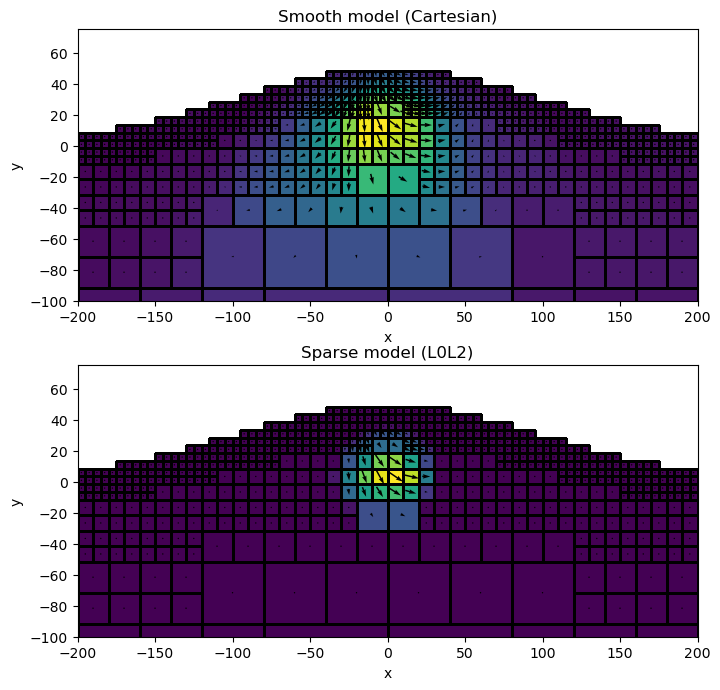

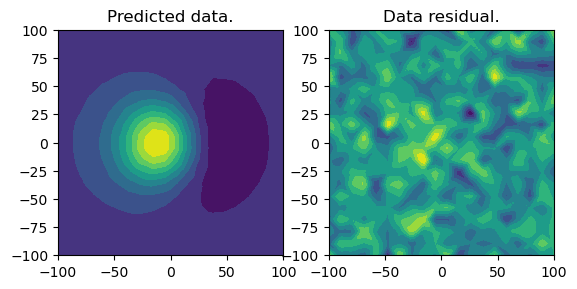

In [7]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 1, 1)
mesh.plot_slice(
    actv_plot * mrec_MVIC.reshape((nC, 3), order="F"),
    v_type="CCv",
    view="vec",
    ax=ax,
    normal="Y",
    ind=66,
    grid=True,
    quiver_opts={
        "pivot": "mid",
        "scale": 5 * np.abs(mrec_MVIC).max(),
        "scale_units": "inches",
    },
)
ax.set_xlim([-200, 200])
ax.set_ylim([-100, 75])
ax.set_title("Smooth model (Cartesian)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")

ax = plt.subplot(2, 1, 2)
vec_xyz = utils.mat_utils.spherical2cartesian(
    mrec_MVI_S.reshape((nC, 3), order="F")
).reshape((nC, 3), order="F")

mesh.plot_slice(
    actv_plot * vec_xyz,
    v_type="CCv",
    view="vec",
    ax=ax,
    normal="Y",
    ind=66,
    grid=True,
    quiver_opts={
        "pivot": "mid",
        "scale": 5 * np.abs(vec_xyz).max(),
        "scale_units": "inches",
    },
)
ax.set_xlim([-200, 200])
ax.set_ylim([-100, 75])
ax.set_title("Sparse model (L0L2)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")

plt.show()

# Plot the final predicted data and the residual
plt.figure()
ax = plt.subplot(1, 2, 1)
utils.plot_utils.plot2Ddata(xyzLoc, invProb.dpred, ax=ax)
ax.set_title("Predicted data.")
plt.gca().set_aspect("equal", adjustable="box")

ax = plt.subplot(1, 2, 2)
utils.plot_utils.plot2Ddata(xyzLoc, synthetic_data - invProb.dpred, ax=ax)
ax.set_title("Data residual.")
plt.gca().set_aspect("equal", adjustable="box")